Learn iterator for multiphase elastic problems using SAC-FEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce

from utils import plot
import feanet.pac as pac
from feanet.model import PACFEANet
from feanet.jacobi import JacobiBlock
from data.dataset import ElasticityDataSet

In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, size, n_elem, mode, dev):
        self.size = size # actual size of the plate
        self.mode = mode
        self.device = dev
        self.n_elem = n_elem
        self.h = size/n_elem
        self.net = self.InstantiateNetwork()
        self.jac = JacobiBlock(self.net, self.h, self.device, self.mode)

    def IsCoarsest(self):
        return self.n_elem == 2
        
    def InstantiateNetwork(self):
        model = PACFEANet(self.device, self.mode).double()
        model.requires_grad_(False)
        return model.to(self.device)

Test SAC-FEANet for elastic problems

In [4]:
model_name = 'elasticity_type1_2d_33x33'
training_set = ElasticityDataSet('data/elasticity_planestress/elasticity_type1_2d_33x33.h5', device)
model_dir = 'model/learn_iterator/elasticity_type1'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

bs = 8
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, fbody_train, usol_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

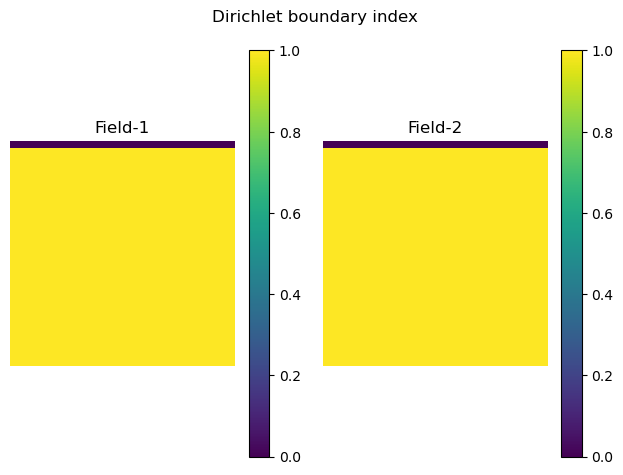

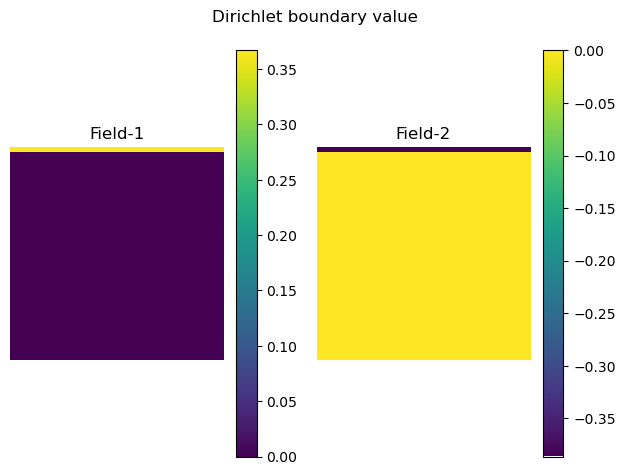

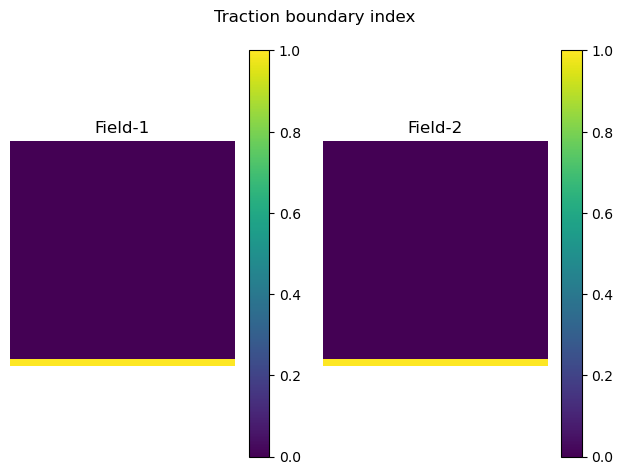

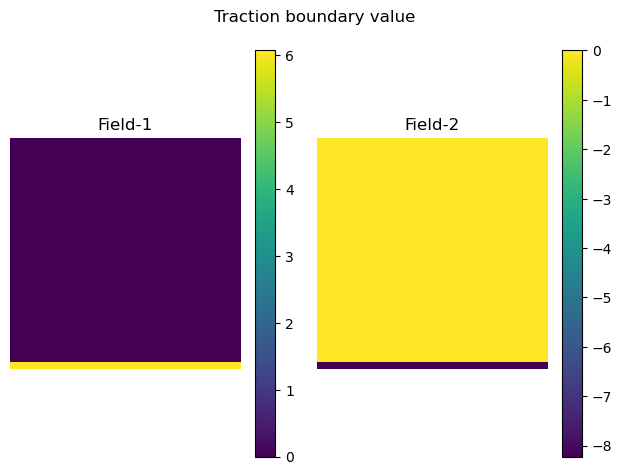

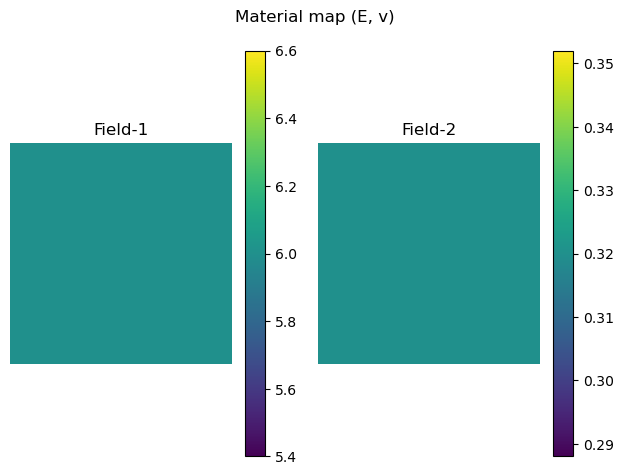

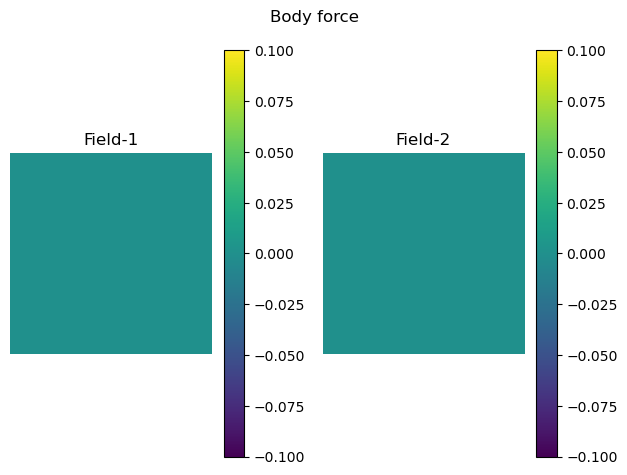

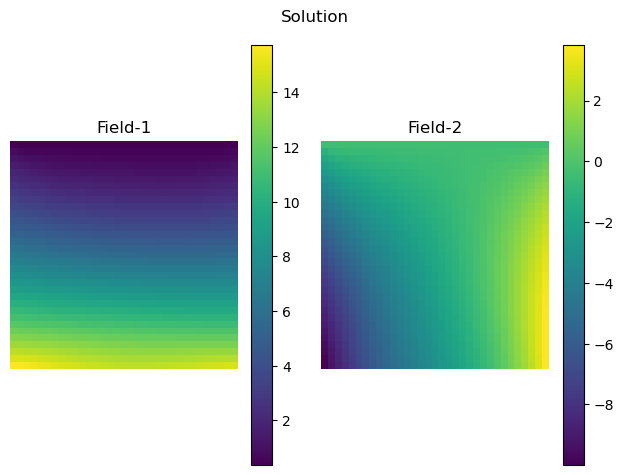

In [5]:
plot.plot_elasticfield(dirich_idx_train[k], ftitle='Dirichlet boundary index')
plot.plot_elasticfield(dirich_value_train[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(traction_idx_train[k], ftitle='Traction boundary index')
plot.plot_elasticfield(traction_value_train[k], ftitle='Traction boundary value')
plot.plot_elasticfield(material_train[k], ftitle='Material map (E, v)')
plot.plot_elasticfield(fbody_train[k], ftitle='Body force')
plot.plot_elasticfield(usol_train[k], ftitle='Solution')

In [6]:
domain_size = 2
n_elem = 2**5
ku, kf = 2, 2
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='elastic', dev=device_predict)

In [7]:
EPS = 1e-6
n_jac = 0
u_train = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
solution_train, f_train, d_train, d_idx_train, t_train, t_idx_train, m_train = (torch.unsqueeze(usol_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(fbody_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(traction_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(traction_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


0 52.81394913789936


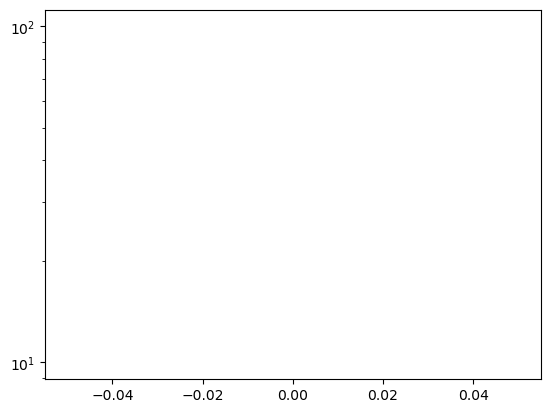

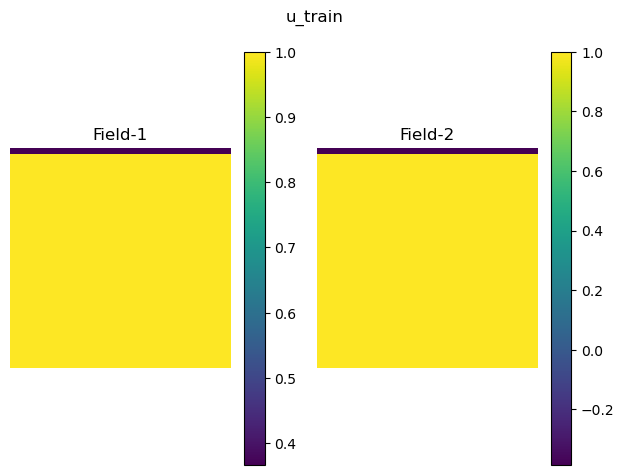

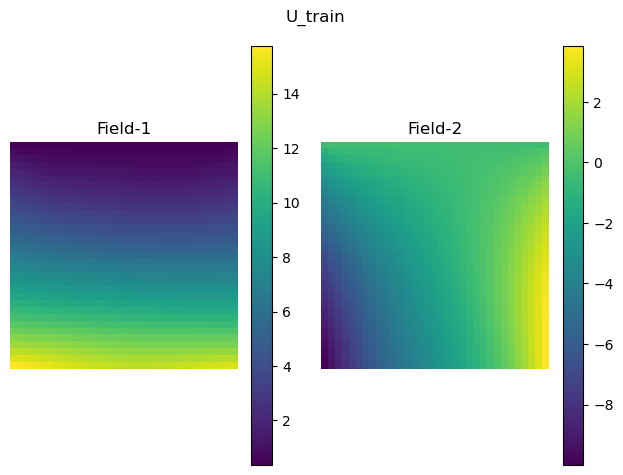

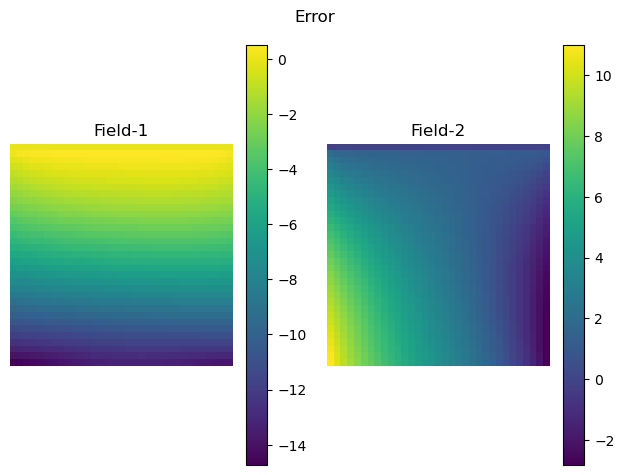

In [8]:
u_train = grid.jac.reset_boundary(u_train, d_train, d_idx_train)
residual = grid.net(h, u_train, f_train, t_train, t_idx_train, m_train)
res = torch.norm(residual[:, :, 1:, :]).item() # fix top, apply traction force at bottom boundary
res_arr = [res]
print(n_jac, res)

'''
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(h, u_train, f_train, t_train, t_idx_train, d_train, d_idx_train, m_train)
    residual = grid.net(h, u_train, f_train, t_train, t_idx_train, m_train)
    res = torch.norm(residual[:, :, 1:, :]).item()
    res_arr.append(res)
    n_jac += 1
    print(n_jac, res)

print("Solution converges after", n_jac, "Jacobi iterations ")
'''

plt.plot(res_arr)
plt.yscale('log')
plt.show()

plot.plot_elasticfield(u_train[0], "u_train")
plot.plot_elasticfield(solution_train[0], "U_train")
plot.plot_elasticfield(u_train[0]-solution_train[0], 'Error')

In [9]:
class PsiNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(PsiNet, self).__init__()

        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        '''
        self.attention_map = nn.Sequential(
            nn.Conv2d(self.km, 1, kernel_size=2, padding=1),
            nn.Conv2d(1, 1, kernel_size=5, padding=2),
            nn.Conv2d(1, self.ku, kernel_size=1, padding=0),
            nn.BatchNorm2d(num_features=self.ku),
            nn.Unfold(kernel_size=3, padding=1),
            nn.Sigmoid()
            )
        '''

        self.smoother = nn.ModuleList([nn.Conv2d(self.ku, self.ku, 3, padding=1, bias=False, groups=self.ku)
                                         for _ in range(nb_layers)])

    def forward(self, m, x, dirich_idx):
        '''
        m: material field
        x: error between Jacobi solution and initial guess '''
        #bs0, ku0, h0, w0 = x.size()
        #new_x = F.unfold(x, kernel_size = 3, padding = 1).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        #attention = self.attention_map(m).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        #attention_x = new_x * attention # shape (bs, ku, 9, h, w)
        #attention_x = attention_x.sum(dim=2) # shape (bs, ku, h, w)
        return reduce(lambda acc, el: el(acc) * dirich_idx, self.smoother, x) # shape (bs, ku, h, w)

In [10]:
class PsiIterator(nn.Module):
    def __init__(self, 
                 dev,
                 size=2, 
                 psi_net=None,
                 grid=None,
                 n=2**5,
                 batch_size=1,
                 max_epochs=1000,
                 mode='thermal',
                 model_dir=model_dir):
        super(PsiIterator, self).__init__()
        self.size = size
        self.device = dev
        self.n = n
        self.h = size/n
        self.mode = mode
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss(reduction='sum')
        
        if(grid is None):
            self.grid = SingleGrid(size, n, mode=mode, dev=self.device)
        else:
            self.grid = grid

        if(psi_net is None):
            self.psi_net = PsiNet(nb_layers=3, mode=self.mode).to(self.device).double()
        else:
            self.psi_net = psi_net.to(self.device).double()

        self.optimizer = torch.optim.Adadelta(self.psi_net.parameters())
        self.model_dir=model_dir

    def PsiRelax(self, h, v, f, t, t_idx, d, d_idx, m, num_sweeps_down):
        '''
        Perform a fixed number of Psi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(h, u, f, t, t_idx, d, d_idx, m)
            u = jac_it + self.psi_net(m, jac_it-u, d_idx) 
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x).double().to(self.device)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = data
        
            #print(u_train.shape)
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            uu = self.RandomSampling(f_train)
            u_out = self.PsiRelax(self.h, uu, f_train, traction_value_train, traction_idx_train, dirich_value_train, dirich_idx_train, material_train, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        loss_train[0] = avg_loss
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.psi_net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train

In [11]:
'''
my_iterator = PsiIterator(device, batch_size=bs, mode='elastic', max_epochs=2000)
loss_train = my_iterator.Train(training_set)

plt.plot(loss_train)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))
'''

'\nmy_iterator = PsiIterator(device, batch_size=bs, mode=\'elastic\', max_epochs=2000)\nloss_train = my_iterator.Train(training_set)\n\nplt.plot(loss_train)\nplt.ylabel(\'loss\')\nplt.yscale(\'log\')\nplt.xlabel(\'epoch\')\nprint("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))\n\n# save the list\ntorch.save(loss_train, os.path.join(model_dir,model_name+\'.pt\'))\n'

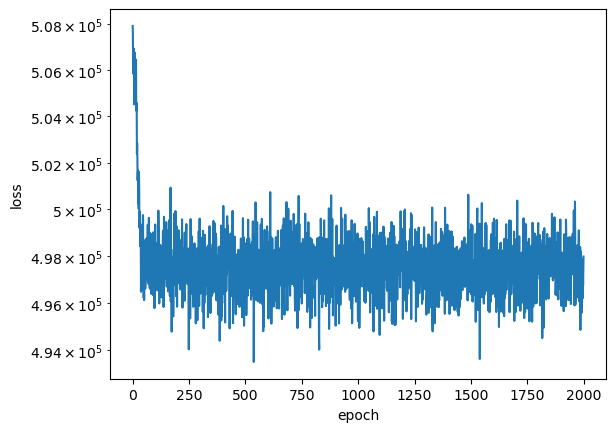

In [12]:
# import the learned model and loss train
my_net = PsiNet(mode='elastic').to(device_predict)
my_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = PsiIterator(device_predict, psi_net=my_net, n=n_elem, batch_size=1, mode='elastic')

my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

0 52.81394913789936
1 17.107193425127548
2 7.958596705305052
3 5.8714384287543036
4 5.046042610569658
5 4.566498253938321
6 4.440012413232286
7 4.269620898029707
8 4.477199135590124
9 4.624679306902323
10 5.5100547081980205
11 6.7169994492678615
12 9.427389984393017
13 13.424512876278156
14 20.30213583460551
15 30.7122463454303
16 47.34334391742407
17 72.95172519265964
18 113.0635936497965
19 175.23383458260562
20 272.0594173183434
21 422.44381213866006
22 656.3190000822511
23 1019.8213716550442
24 1584.9483734735934
25 2463.5124868180037
26 3829.8162173795026
27 5955.759350585129
28 9264.756768020527
29 14410.966867171275
30 22388.249654366096
31 34668.76445332119
32 53360.93105701074
33 81364.15183709704
34 122478.46447270528
35 181406.84937749643
36 263567.15554759366
37 374629.0857105148
38 519740.1090639713
39 702580.6232398405
40 924847.0222448723
41 1187812.7932841976
42 1499684.3697457644
43 1895065.1095398194
44 2469983.9202780635
45 3413799.7123605474
46 4996708.654326509
47 

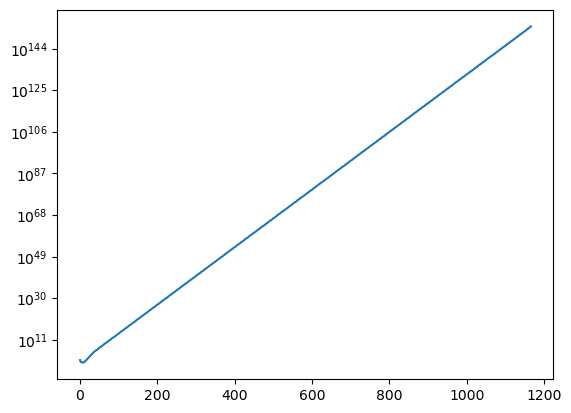

In [13]:
EPS = 1e-6
n_new = 0
u_train = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_train = new_iterator.grid.jac.reset_boundary(u_train, d_train, d_idx_train)
residual = new_iterator.grid.net(h, u_train, f_train, t_train, t_idx_train, m_train)
res = torch.norm(residual[:, :, 1:, :]).item() # fix top, apply traction force at bottom boundary
res_arr_new = [res]
print(n_new, res)
while (abs(res) > EPS):
    u_train = new_iterator.PsiRelax(h, u_train, f_train, t_train, t_idx_train, d_train, d_idx_train, m_train, 1)
    residual = new_iterator.grid.net(h, u_train, f_train, t_train, t_idx_train, m_train)
    res = torch.norm(residual[:, :, 1:, :]).item()
    res_arr_new.append(res)
    n_new += 1
    print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new)
plt.yscale('log')


In [14]:
# test on larger grid
n_elem = 2**6
test_set = ElasticityDataSet('data/elasticity_planestress/elasticity_type1_2d_65x65.h5', device=device)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=True)
dirich_idx_test, dirich_value_test, traction_idx_test, traction_value_test, material_test, fbody_test, usol_test = next(iter(test_dataloader))

solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(usol_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(fbody_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(traction_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(traction_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict))
#plot.plot_elasticfield(solution_test[k])
#plot.plot_elasticfield(d_test[k])
#lot.plot_elasticfield(t_test[k])

In [15]:
test_iterator = PsiIterator(device_predict, psi_net=my_net, n=2**6, batch_size=1, mode='elastic')


0 57.05174756608061
1 19.423809244072622
2 9.539092497034495
3 7.006556869309692
4 6.063429367790047
5 5.441028689389079
6 5.34760775932018
7 5.1732026933392135
8 5.525127819594989
9 5.7366275082285965
10 6.87988471460368
11 8.236996968706324
12 11.419394834153564
13 15.905866048738936
14 23.85211510605873
15 35.6737595608149
16 54.781159670414254
17 83.99099941858242
18 130.03844826576318
19 201.4020546745336
20 313.30308991572775
21 487.95090744846146
22 761.8665620312979
23 1191.164677134258
24 1865.6415353843279
25 2925.8764055133465
26 4595.099024718345
27 7225.413092526117
28 11375.160695203289
29 17928.247087958724
30 28287.24357013551
31 44677.72385876242
32 70635.85223909507
33 111783.12399963097
34 177064.6643111108
35 280723.8893211938
36 445458.97736014944
37 707466.659704683
38 1124511.5740958233
39 1788839.5729932413
40 2847859.0521319243
41 4537278.056458985
42 7234231.5173633415
43 11542498.725337489
44 18429266.110305093
45 29444715.21247226
46 47074760.072401956
47 75

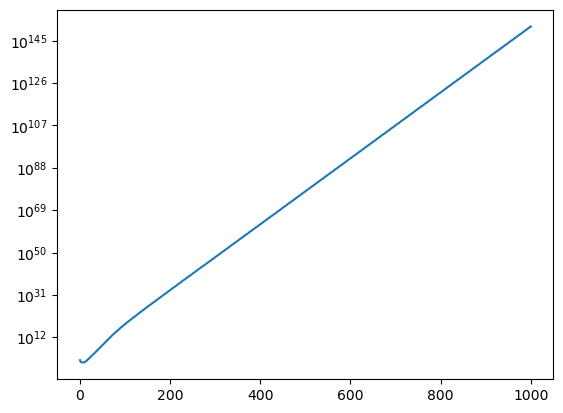

In [16]:
EPS = 1e-6
n_new = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = test_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = test_iterator.grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual[:, :, 1:, :]).item() # fix top, apply traction force at bottom boundary
res_arr_new = [res]
print(n_new, res)
while (abs(res) > EPS and n_new < 1000):
    u_test = test_iterator.PsiRelax(h, u_test, f_test, t_test, t_idx_test, d_test, d_idx_test, m_test, 1)
    residual = test_iterator.grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual[:, :, 1:, :]).item()
    res_arr_new.append(res)
    n_new += 1
    print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new)
plt.yscale('log')

0 57.05174756608061
1 26.873193426537366
2 18.95752822971635
3 15.127190995892564
4 12.77939749502902
5 11.168262915503682
6 9.980401387502264
7 9.06479313334496
8 8.334190095365177
9 7.736472701596307
10 7.237252184899684
11 6.813447684968282
12 6.448654057497356
13 6.131022084602393
14 5.851691981834659
15 5.6039363696974425
16 5.382531420262209
17 5.18336479228376
18 5.003147962502558
19 4.839220299075978
20 4.689403662218072
21 4.55189739490582
22 4.425198975418996
23 4.308044369232615
24 4.199362043335187
25 4.098237379315892
26 4.00388469909013
27 3.9156251264012387
28 3.832868873596999
29 3.7551009666404784
30 3.68186964308906
31 3.6127768582360136
32 3.547470461860862
33 3.4856377118949964
34 3.4269998642508934
35 3.371307635460519
36 3.3183373773374303
37 3.2678878361297734
38 3.2197773940885166
39 3.1738417113571185
40 3.1299317017072763
41 3.0879117880185887
42 3.0476583932209786
43 3.0090586302802635
44 2.972009161125611
45 2.9364151995274828
46 2.9021896370856126
47 2.8692

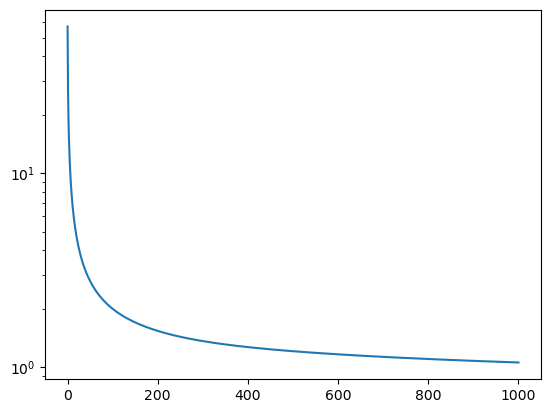

In [20]:
EPS = 1e-6
n_jac = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = test_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = test_iterator.grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual[:, :, 1:, :]).item() # fix top, apply traction force at bottom boundary
res_arr_new_jac = [res]
print(n_jac, res)

while (abs(res) > EPS and n_jac < 1000):
    u_test = test_iterator.grid.jac.jacobi_convolution(h, u_test, f_test, t_test, t_idx_test, d_test, d_idx_test, m_test)
    residual = test_iterator.grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual[:, :, 1:, :]).item()
    res_arr_new_jac.append(res)
    n_jac += 1
    print(n_jac, res)

print("Solution converges after", n_jac, "iterations ")
plt.plot(res_arr_new_jac)
plt.yscale('log')

In [18]:
# test multigrid performance

class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, chs):
        super(RestrictionNet, self).__init__()
        self.chs = chs
        self.net = nn.Conv2d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restriction
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
    def forward(self, x):
        return self.net(x)


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, chs):
        super(ProlongationNet, self).__init__()
        self.chs = chs
        self.net = nn.ConvTranspose2d(in_channels=chs,out_channels=chs, kernel_size=3, stride=2, padding=1, bias=False, groups=chs) # interpolation
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            
    def forward(self, x): 
        return self.net(x)

In [19]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, pacnet, device, mode='thermal', iterator = 'jac'):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.device = device
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.pacnet = pacnet
        self.iterator = iterator
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.iterators = self.IteratorDict() # dictionary of iterators

        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2

        # Inter-grid communication network models
        self.conv = RestrictionNet(self.kf)
        self.deconv = ProlongationNet(self.ku)
        
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)

        self.mse_loss = nn.MSELoss()
    
    def IteratorDict(self):
        iterators = {}
        for i in range(self.L):
            iterators[i] = PsiIterator(self.device, size=self.size, psi_net=self.pacnet, n=self.n_arr[i])
        return iterators        
            
    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def loss(self, uk, k):
        "Compute the loss after k iterations, uk is current solution"
        res_k = self.f - self.iterators[0].grid.Knet(uk)
        res_last = self.f - self.iterators[0].grid.Knet(self.last_v)
        return torch.mean(torch.norm(res_k[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res_last[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach())

    def forward(self, u0, F, bc_idx, bc_value, k):
        '''Input is initial solution u0, RHS field F, boundary value B, iteration number k'''
        self.f = self.iterators[0].grid.fnet(F) # assign the finest rhs 
        self.iterators[0].grid.ResetBoundary(bc_idx, bc_value) # reset the boundary of finest grid
        self.u0 = self.iterators[0].grid.jac.reset_boundary(u0)
        U = self.u0.clone()
        
        for i in range(k-1):
            U = self.Step(U, self.f).detach()
        self.last_v = U.clone()
        return self.Step(U, self.f)

    def Relax(self, iter, u, f, n_iter):
        if(self.iterator == 'jac'):
            return iter.grid.jac.jacobi_convolution(u, f)
        else:
            return iter.PsiRelax(u, f, n_iter)

    def Step(self, v, f):
        '''Input v is the initial solution on the finest grid'''
        n_batches = v.shape[0]
        n_relax = 1 # number of relaxations
        self.iterators[0].grid.v = v
        self.iterators[0].grid.f = f
        self.iterators[0].grid.v = self.Relax(self.iterators[0], self.iterators[0].grid.v, self.iterators[0].grid.f, n_relax)

        for j in range(0, self.L-1):
            rF = self.iterators[j].grid.f-self.iterators[j].grid.Knet(self.iterators[j].grid.v)
            rF = self.iterators[j].grid.Knet.split_x(rF)
            self.iterators[j+1].grid.f = self.Restrict(rF)
            self.iterators[j+1].grid.v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.iterators[j+1].grid.v = self.Relax(self.iterators[j+1], self.iterators[j+1].grid.v, self.iterators[j+1].grid.f, n_relax)

        self.iterators[self.L-1].grid.v = self.Relax(self.iterators[self.L-1], self.iterators[self.L-1].grid.v, self.iterators[self.L-1].grid.f, n_relax)

        for j in range(self.L-2,-1,-1):
            eFC = self.iterators[j+1].grid.Knet.split_x(self.iterators[j+1].grid.v)
            eF_delta = self.Interpolate(eFC)
            self.iterators[j].grid.v = self.iterators[j].grid.v + eF_delta
            self.iterators[j].grid.v = self.Relax(self.iterators[j], self.iterators[j].grid.v, self.iterators[j].grid.f, n_relax)

            # zero out the previous level solution
            self.iterators[j+1].grid.v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.iterators[0].grid.v 